In [1]:
# -*- coding: utf-8 -*-
"""
Model-Agnostic Meta-Learning on mnist

https://arxiv.org/pdf/1703.03400.pdf

Created on Jan 2019

@author: zyf
"""
import numpy as np
import random
import time
from mnist import MNIST
import matplotlib.pyplot as plt

from DataLoader import DataLoader

mndata = MNIST('data')
images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()


In [2]:
### Split data ###

n_category = 10
category_train = [0,1,2,3,4,5,6,7]
category_test = [8,9]

d = len(images_train[0])
images_train = images_train[:20000]
labels_train = labels_train[:20000]
images_test = images_test[-20000:]
labels_test = labels_test[-20000:]

images_train_categories = [[] for _ in range(n_category)]
images_test_categories = [[] for _ in range(n_category)]

for idx in range(len(images_train)):
    category = labels_train[idx]
    if category in category_train:
        images_train_categories[category].append([1]+images_train[idx])

for idx in range(len(labels_test)):
    category = labels_test[idx]
    if category in category_test:
        images_test_categories[category].append([1]+images_test[idx])
    

# initialize dataloader
trainLoaders = []
testLoaders = []

# k_shots = 2
# batch_size = 2*k_shots     # mini batch size for training

for c in range(n_category):
    if c in category_train:
        trainLoaders.append(DataLoader(np.array([(i+[c]) for i in images_train_categories[c]])))
        trainLoaders[-1].reset(0)
    if c in category_test:
        testLoaders.append(DataLoader(np.array([(i+[c]) for i in images_test_categories[c]])))
        testLoaders[-1].reset(0)

[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1994
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 2281
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1929
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 2076
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1945
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1775
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1971
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 2093
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 974
[DataLoader]: initialized successfully
[DataLoader]: dataset size -- 1009


In [3]:

def sigmoid(x):
    # support matrix
    return 1.0/(1+np.exp(-x))

def learnRate(t, learn_rate_ini, T):
    return learn_rate_ini/(1+t/T)

def accuracyLogi(t,y):
    # support matrix
    p = np.where(y<0.50, 1, 0)
    return np.mean(t^p)


In [4]:
# Compute first order approximation gradient of theta_prime for a single task

def getGradient(inputs_a, targets_a, inputs_b, targets_b, w, is_train):

    # support set
    # compute gradient
    x = np.concatenate((inputs_a[:k_shots], inputs_b[:k_shots]), axis=0)
    t = np.concatenate((targets_a[:k_shots], targets_b[:k_shots]), axis=0)
    y = sigmoid(np.dot(x,w))    
    loss_train = (np.dot(t.transpose(), np.log(y)) + np.dot(1-t.transpose(), np.log(1-y))).item()
    accu_train = accuracyLogi(t,y)
    gw = np.dot(x.transpose(),t-y) / k_shots    # negative gradient
    
    w_star = w + learn_rate_alpha*gw    # calculate updated parameter

    # query set 
    # use updated w_star as parameter to evaluate and compute gradient
    x = np.concatenate((inputs_a[k_shots:], inputs_b[k_shots:]), axis=0)
    t = np.concatenate((targets_a[k_shots:], targets_b[k_shots:]), axis=0)
    y = sigmoid(np.dot(x,w_star))    
    loss_query = (np.dot(t.transpose(), np.log(y)) + np.dot(1-t.transpose(), np.log(1-y))).item()
    accu_query = accuracyLogi(t,y)

    gw_star = np.dot(x.transpose(),t-y) / k_shots    # negative gradient
    gradient = gw_star if is_train else gw
        
    return gradient, accu_train, accu_query

In [5]:
# Sample 1) batch of tasks; 2) k-shots data points

def getSamples(is_train):
        
    dataLoaders = trainLoaders if is_train else testLoaders
    ctgy_range = len(category_train) if is_train else len(category_test)
    sample_size = batch_size if is_train else 0
    
    # sample two categories randomly, then sample k-shots data points inside
    ctgy_samples = np.random.choice(ctgy_range, 2, replace=False)
    ctgy_alpha = ctgy_samples[0] if ctgy_samples[0] < ctgy_samples[1] else ctgy_samples[1]
    ctgy_bravo = ctgy_samples[1] if ctgy_samples[0] < ctgy_samples[1] else ctgy_samples[0]
    dataLoaders[ctgy_alpha].reset(sample_size)
    dataLoaders[ctgy_bravo].reset(sample_size)
    inputs_alpha, targets_alpha, _ = dataLoaders[ctgy_alpha].getMiniBatch()
    inputs_bravo, targets_bravo, _ = dataLoaders[ctgy_bravo].getMiniBatch()
    targets_alpha = np.where(targets_alpha>0, 0, 1)
    targets_bravo = np.where(targets_bravo>0, 1, 0)
    
    return_data = (inputs_alpha, targets_alpha, inputs_bravo, targets_bravo)
    return return_data

In [6]:
# A single episode for meta-learning (either for train or fine-tune)

def oneEpisode(is_meta=True, is_train=True):
    
    global w_meta
    w_copy = w_meta + 0  # make copy
    w_base = np.zeros((d+1,1))  # baseline parameter initialize
    gw_meta_avg, gw_base_avg = 0, 0
    
    n_task = 2 if is_train else 1
    max_iter = 1 if is_train else 16
    
    task_pool = []
    for i_task in range(n_task):
        task_pool.append(getSamples(is_train))
        
    for iter_i in range(max_iter):
        
        for task_data in task_pool:

            inputs_alpha, targets_alpha, inputs_bravo, targets_bravo = task_data
            
            gw_meta, accu_train_meta, accu_query_meta = getGradient(inputs_alpha, targets_alpha, inputs_bravo, targets_bravo, w_meta, is_train)
            gw_meta_avg += gw_meta / n_task
            
            accu_train_base, accu_query_base = 0, 0

            if is_train: continue
                
            gw_base, accu_train_base, accu_query_base = getGradient(inputs_alpha, targets_alpha, inputs_bravo, targets_bravo, w_base, is_train)
            gw_base_avg += gw_base / n_task
            
            # display inside epoch
            if (iter_i + 1) % disp_round == 0:
                if (iter_i + 1) == disp_round: print("\n")
                print ("iteration:", iter_i + 1, end='\t')
                # print (loss_train, reg_loss, loss_valid, loss_test)
                print (round(accu_train_meta/(0+1), 3), round(accu_query_meta/(0+1), 3), round(accu_train_base/(0+1), 3), round(accu_query_base/(0+1), 3))
        
        learning_rate = learn_rate_beta if is_train else learn_rate_alpha
        w_meta += learning_rate * gw_meta_avg
        w_base += amplifier * learning_rate * gw_base_avg
    
    if not is_train:
        w_meta = w_copy
        
    return accu_query_meta, accu_query_base

In [7]:
def testProcedure():

    print("intermediate testing...")
    print(time.asctime( time.localtime(time.time()) ))
    print("\n")

    max_sample = 20
    accu_meta_avg, accu_base_avg = 0, 0

    for i in range(max_sample):
        accu_meta, accu_base = oneEpisode(is_meta=False, is_train=False)
        accu_meta_avg += accu_meta / max_sample
        accu_base_avg += accu_base / max_sample
        if (i+1)%10==0:
            print('Sample (test):', i+1, '\tAccuracy:', round(accu_meta, 3), round(accu_base, 3))
            print(time.asctime( time.localtime(time.time()) ))
            print("\n")

    print("[test]: Average accuracy:", accu_meta_avg, accu_base_avg)
    print("\n")
    return accu_meta_avg, accu_base_avg

In [8]:

k_shots = 2
batch_size = 2*k_shots     # mini batch size for training
max_epsd = 20000
learn_rate_alpha = 5e-9    # meta update step size alpha
learn_rate_beta = 2e-9    # meta update step size beta
# learn_rate_tuning = 1e-9    # finetuning step size
amplifier = 10    # indicate larger step size for baseline finetuning, should be 1 in fact ?
# T = 5000000
# lam = 0.0001
disp_round = 4

w_meta = np.zeros((d+1,1))
loss_record = [[],[],[]]
accu_record = [[],[],[]]


print("Begin training...")
print(time.asctime( time.localtime(time.time()) ))
print("\n")

for i in range(max_epsd):
    accu_meta, _ = oneEpisode(is_meta=True, is_train=True)
    if (i+1)%100==0:
        print('Epoch (train):', i+1, '\tAccuracy:', round(accu_meta, 3))
        print(time.asctime( time.localtime(time.time()) ))
        print(np.sum(np.square(w_meta)))
        print("\n")
    if (i+1)%1000==0:
        accu_meta, accu_base = testProcedure()
        accu_record[0].append(accu_meta)
        accu_record[1].append(accu_base)


Begin training...
Fri Mar  1 14:50:10 2019


Epoch (train): 100 	Accuracy: 0.5
Fri Mar  1 14:50:11 2019
9.071439059445616e-09


Epoch (train): 200 	Accuracy: 0.5
Fri Mar  1 14:50:12 2019
2.986148891529366e-08


Epoch (train): 300 	Accuracy: 1.0
Fri Mar  1 14:50:13 2019
5.542987241159413e-08


Epoch (train): 400 	Accuracy: 0.5
Fri Mar  1 14:50:14 2019
8.532621961621952e-08


Epoch (train): 500 	Accuracy: 1.0
Fri Mar  1 14:50:15 2019
1.2192719229261895e-07


Epoch (train): 600 	Accuracy: 0.5
Fri Mar  1 14:50:16 2019
1.502414459108707e-07


Epoch (train): 700 	Accuracy: 0.5
Fri Mar  1 14:50:17 2019
1.8009461490501386e-07


Epoch (train): 800 	Accuracy: 1.0
Fri Mar  1 14:50:18 2019
2.1124030044775994e-07


Epoch (train): 900 	Accuracy: 0.5
Fri Mar  1 14:50:19 2019
2.4252706539858447e-07


Epoch (train): 1000 	Accuracy: 0.5
Fri Mar  1 14:50:20 2019
2.6885261158742113e-07


intermediate testing...
Fri Mar  1 14:50:20 2019




iteration: 4	0.5 0.509 1.0 0.638
iteration: 8	0.5 0.525 1.0 0.654


Epoch (train): 2800 	Accuracy: 0.5
Fri Mar  1 14:50:54 2019
9.966234298747255e-07


Epoch (train): 2900 	Accuracy: 0.5
Fri Mar  1 14:50:55 2019
1.0428825104201593e-06


Epoch (train): 3000 	Accuracy: 0.5
Fri Mar  1 14:50:56 2019
1.092231828387094e-06


intermediate testing...
Fri Mar  1 14:50:56 2019




iteration: 4	0.5 0.533 1.0 0.637
iteration: 8	0.5 0.594 1.0 0.638
iteration: 12	1.0 0.729 1.0 0.639
iteration: 16	1.0 0.803 1.0 0.64


iteration: 4	0.5 0.532 1.0 0.677
iteration: 8	0.5 0.578 1.0 0.665
iteration: 12	1.0 0.713 1.0 0.655
iteration: 16	1.0 0.814 1.0 0.645


iteration: 4	0.5 0.532 1.0 0.777
iteration: 8	0.75 0.579 1.0 0.772
iteration: 12	1.0 0.702 1.0 0.77
iteration: 16	1.0 0.841 1.0 0.766


iteration: 4	0.5 0.537 1.0 0.726
iteration: 8	0.5 0.617 1.0 0.791
iteration: 12	1.0 0.774 1.0 0.808
iteration: 16	1.0 0.823 1.0 0.802


iteration: 4	0.5 0.527 1.0 0.544
iteration: 8	0.5 0.539 1.0 0.573
iteration: 12	0.5 0.579 1.0 0.62
iteration: 16	1.0 0.655 1.0 0.68


iteration: 4	0.75

iteration: 8	0.75 0.66 1.0 0.895
iteration: 12	1.0 0.753 1.0 0.887
iteration: 16	1.0 0.834 1.0 0.879


iteration: 4	0.75 0.589 1.0 0.628
iteration: 8	0.75 0.638 1.0 0.721
iteration: 12	1.0 0.71 1.0 0.807
iteration: 16	1.0 0.793 1.0 0.846


iteration: 4	0.5 0.614 0.5 0.491
iteration: 8	0.5 0.738 0.5 0.492
iteration: 12	0.75 0.824 1.0 0.628
iteration: 16	0.5 0.611 1.0 0.814


iteration: 4	0.5 0.589 1.0 0.721
iteration: 8	0.5 0.642 1.0 0.771
iteration: 12	1.0 0.722 1.0 0.816
iteration: 16	1.0 0.807 1.0 0.842


iteration: 4	0.5 0.604 1.0 0.759
iteration: 8	0.5 0.698 1.0 0.778
iteration: 12	1.0 0.819 1.0 0.806
iteration: 16	1.0 0.817 1.0 0.812


iteration: 4	0.75 0.597 1.0 0.801
iteration: 8	0.75 0.672 1.0 0.844
iteration: 12	1.0 0.768 1.0 0.848
iteration: 16	1.0 0.828 1.0 0.839


iteration: 4	0.5 0.586 1.0 0.847
iteration: 8	0.75 0.624 1.0 0.854
iteration: 12	1.0 0.69 1.0 0.868
iteration: 16	1.0 0.764 1.0 0.875


iteration: 4	0.5 0.592 1.0 0.854
iteration: 8	0.75 0.649 1.0 0.866
iteration:

iteration: 8	1.0 0.644 1.0 0.86
iteration: 12	1.0 0.675 1.0 0.861
iteration: 16	1.0 0.714 1.0 0.864


iteration: 4	0.5 0.645 0.75 0.532
iteration: 8	0.5 0.736 0.75 0.592
iteration: 12	1.0 0.828 1.0 0.652
iteration: 16	1.0 0.796 1.0 0.718


iteration: 4	0.75 0.634 1.0 0.672
iteration: 8	0.75 0.685 1.0 0.708
iteration: 12	1.0 0.752 1.0 0.744
iteration: 16	1.0 0.799 1.0 0.754


iteration: 4	0.75 0.626 1.0 0.67
iteration: 8	0.75 0.664 1.0 0.701
iteration: 12	0.75 0.709 1.0 0.732
iteration: 16	0.75 0.759 1.0 0.718
Sample (test): 10 	Accuracy: 0.759 0.718
Fri Mar  1 14:52:14 2019




iteration: 4	0.5 0.629 1.0 0.647
iteration: 8	0.5 0.668 1.0 0.671
iteration: 12	1.0 0.735 1.0 0.698
iteration: 16	1.0 0.805 1.0 0.716


iteration: 4	0.5 0.634 1.0 0.784
iteration: 8	1.0 0.697 1.0 0.851
iteration: 12	1.0 0.768 1.0 0.873
iteration: 16	1.0 0.832 1.0 0.871


iteration: 4	0.5 0.647 0.5 0.498
iteration: 8	0.75 0.736 1.0 0.643
iteration: 12	0.75 0.847 1.0 0.843
iteration: 16	0.75 0.79 1.0 0.851


itera

iteration: 8	0.75 0.736 1.0 0.686
iteration: 12	0.5 0.824 1.0 0.82
iteration: 16	0.75 0.854 1.0 0.858


iteration: 4	0.5 0.671 1.0 0.606
iteration: 8	0.75 0.712 1.0 0.603
iteration: 12	0.75 0.758 1.0 0.604
iteration: 16	1.0 0.807 1.0 0.604


iteration: 4	0.75 0.674 1.0 0.82
iteration: 8	0.75 0.726 1.0 0.86
iteration: 12	1.0 0.783 1.0 0.872
iteration: 16	1.0 0.84 1.0 0.87


iteration: 4	1.0 0.672 1.0 0.715
iteration: 8	1.0 0.71 1.0 0.776
iteration: 12	1.0 0.764 1.0 0.818
iteration: 16	1.0 0.826 1.0 0.846


iteration: 4	0.5 0.671 1.0 0.763
iteration: 8	0.5 0.711 1.0 0.771
iteration: 12	1.0 0.773 1.0 0.775
iteration: 16	1.0 0.84 1.0 0.782


iteration: 4	0.75 0.677 1.0 0.494
iteration: 8	0.75 0.732 1.0 0.538
iteration: 12	1.0 0.81 1.0 0.684
iteration: 16	1.0 0.854 1.0 0.795


iteration: 4	0.75 0.658 1.0 0.594
iteration: 8	0.75 0.669 1.0 0.62
iteration: 12	0.75 0.684 1.0 0.654
iteration: 16	1.0 0.712 1.0 0.687


iteration: 4	0.75 0.668 1.0 0.748
iteration: 8	1.0 0.697 1.0 0.807
iteration: 1

iteration: 8	0.75 0.682 1.0 0.819
iteration: 12	0.75 0.75 1.0 0.815
iteration: 16	1.0 0.826 1.0 0.81


iteration: 4	0.5 0.649 1.0 0.799
iteration: 8	0.75 0.7 1.0 0.864
iteration: 12	1.0 0.776 1.0 0.875
iteration: 16	1.0 0.846 1.0 0.868


iteration: 4	0.75 0.639 1.0 0.606
iteration: 8	0.75 0.671 1.0 0.638
iteration: 12	1.0 0.704 1.0 0.644
iteration: 16	1.0 0.741 1.0 0.643


iteration: 4	0.75 0.639 1.0 0.755
iteration: 8	1.0 0.664 1.0 0.78
iteration: 12	1.0 0.701 1.0 0.771
iteration: 16	1.0 0.736 1.0 0.765


iteration: 4	0.75 0.644 1.0 0.51
iteration: 8	1.0 0.687 1.0 0.556
iteration: 12	1.0 0.752 1.0 0.634
iteration: 16	1.0 0.815 1.0 0.689


iteration: 4	0.5 0.658 1.0 0.495
iteration: 8	0.5 0.735 1.0 0.549
iteration: 12	1.0 0.84 1.0 0.737
iteration: 16	1.0 0.796 1.0 0.857
Sample (test): 20 	Accuracy: 0.796 0.857
Fri Mar  1 14:53:31 2019


[test]: Average accuracy: 0.8012632642748865 0.8013390601313795


Epoch (train): 11100 	Accuracy: 1.0
Fri Mar  1 14:53:32 2019
4.485142779628419e-06




iteration: 8	0.75 0.681 1.0 0.589
iteration: 12	1.0 0.702 1.0 0.647
iteration: 16	1.0 0.719 1.0 0.693


iteration: 4	0.75 0.674 1.0 0.558
iteration: 8	1.0 0.714 1.0 0.569
iteration: 12	1.0 0.775 1.0 0.579
iteration: 16	1.0 0.806 1.0 0.588
Sample (test): 20 	Accuracy: 0.806 0.588
Fri Mar  1 14:54:07 2019


[test]: Average accuracy: 0.811622031328954 0.774633653360283


Epoch (train): 13100 	Accuracy: 0.75
Fri Mar  1 14:54:08 2019
5.1169582145748e-06


Epoch (train): 13200 	Accuracy: 0.5
Fri Mar  1 14:54:09 2019
5.13942714164751e-06


Epoch (train): 13300 	Accuracy: 0.5
Fri Mar  1 14:54:10 2019
5.161290923620281e-06


Epoch (train): 13400 	Accuracy: 0.75
Fri Mar  1 14:54:11 2019
5.194776414003178e-06


Epoch (train): 13500 	Accuracy: 0.75
Fri Mar  1 14:54:12 2019
5.2168310018572624e-06


Epoch (train): 13600 	Accuracy: 1.0
Fri Mar  1 14:54:13 2019
5.262291132347466e-06


Epoch (train): 13700 	Accuracy: 0.5
Fri Mar  1 14:54:14 2019
5.305719996063381e-06


Epoch (train): 13800 	Accuracy: 0

Epoch (train): 15300 	Accuracy: 1.0
Fri Mar  1 14:54:47 2019
5.72785550431065e-06


Epoch (train): 15400 	Accuracy: 1.0
Fri Mar  1 14:54:48 2019
5.753419285853615e-06


Epoch (train): 15500 	Accuracy: 0.75
Fri Mar  1 14:54:48 2019
5.788209235370969e-06


Epoch (train): 15600 	Accuracy: 1.0
Fri Mar  1 14:54:49 2019
5.819539256511611e-06


Epoch (train): 15700 	Accuracy: 0.5
Fri Mar  1 14:54:50 2019
5.844708000754615e-06


Epoch (train): 15800 	Accuracy: 0.5
Fri Mar  1 14:54:51 2019
5.883572437420012e-06


Epoch (train): 15900 	Accuracy: 1.0
Fri Mar  1 14:54:52 2019
5.911758334300862e-06


Epoch (train): 16000 	Accuracy: 0.5
Fri Mar  1 14:54:53 2019
5.925223492293797e-06


intermediate testing...
Fri Mar  1 14:54:53 2019




iteration: 4	0.75 0.68 1.0 0.733
iteration: 8	0.75 0.697 1.0 0.742
iteration: 12	1.0 0.736 1.0 0.746
iteration: 16	1.0 0.774 1.0 0.751


iteration: 4	0.75 0.681 1.0 0.742
iteration: 8	0.75 0.714 1.0 0.742
iteration: 12	0.75 0.749 1.0 0.747
iteration: 16	1.0 0.795 1.0

Epoch (train): 18000 	Accuracy: 0.5
Fri Mar  1 14:55:29 2019
6.516928433351375e-06


intermediate testing...
Fri Mar  1 14:55:29 2019




iteration: 4	0.75 0.708 1.0 0.79
iteration: 8	0.75 0.744 1.0 0.787
iteration: 12	1.0 0.798 1.0 0.766
iteration: 16	1.0 0.825 1.0 0.753


iteration: 4	0.5 0.707 1.0 0.557
iteration: 8	0.75 0.74 1.0 0.703
iteration: 12	1.0 0.8 1.0 0.837
iteration: 16	1.0 0.833 1.0 0.892


iteration: 4	0.75 0.701 1.0 0.745
iteration: 8	0.75 0.729 1.0 0.778
iteration: 12	0.75 0.77 1.0 0.803
iteration: 16	1.0 0.824 1.0 0.819


iteration: 4	0.75 0.693 1.0 0.662
iteration: 8	1.0 0.701 1.0 0.668
iteration: 12	1.0 0.711 1.0 0.68
iteration: 16	1.0 0.722 1.0 0.685


iteration: 4	0.5 0.71 1.0 0.562
iteration: 8	0.5 0.783 1.0 0.617
iteration: 12	0.75 0.84 1.0 0.663
iteration: 16	1.0 0.79 1.0 0.681


iteration: 4	0.75 0.711 1.0 0.66
iteration: 8	0.75 0.744 1.0 0.769
iteration: 12	0.75 0.799 1.0 0.848
iteration: 16	1.0 0.833 1.0 0.86


iteration: 4	1.0 0.696 1.0 0.841
iteration: 8	

iteration: 8	0.75 0.704 1.0 0.739
iteration: 12	0.75 0.751 1.0 0.751
iteration: 16	1.0 0.792 1.0 0.759


iteration: 4	0.75 0.685 1.0 0.791
iteration: 8	0.75 0.71 1.0 0.837
iteration: 12	0.75 0.752 1.0 0.861
iteration: 16	1.0 0.796 1.0 0.876


iteration: 4	1.0 0.685 1.0 0.796
iteration: 8	1.0 0.715 1.0 0.859
iteration: 12	1.0 0.761 1.0 0.88
iteration: 16	1.0 0.807 1.0 0.893


iteration: 4	0.75 0.693 1.0 0.597
iteration: 8	0.75 0.729 1.0 0.626
iteration: 12	1.0 0.79 1.0 0.651
iteration: 16	1.0 0.798 1.0 0.67


iteration: 4	0.5 0.698 1.0 0.763
iteration: 8	0.75 0.765 1.0 0.76
iteration: 12	1.0 0.842 1.0 0.759
iteration: 16	1.0 0.826 1.0 0.762


iteration: 4	0.5 0.696 1.0 0.684
iteration: 8	0.75 0.754 1.0 0.788
iteration: 12	1.0 0.824 1.0 0.87
iteration: 16	1.0 0.818 1.0 0.893


iteration: 4	0.75 0.685 1.0 0.71
iteration: 8	0.75 0.711 1.0 0.715
iteration: 12	1.0 0.743 1.0 0.713
iteration: 16	1.0 0.78 1.0 0.714
Sample (test): 10 	Accuracy: 0.78 0.714
Fri Mar  1 14:56:10 2019




iteration: 

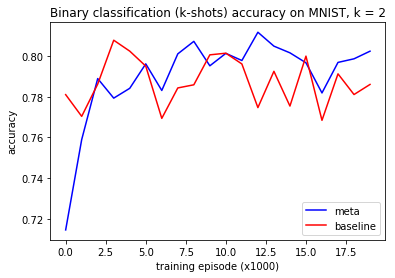

In [9]:
%matplotlib inline

plt.plot(accu_record[0],'b-',label='meta')
plt.plot(accu_record[1],'r-',label='baseline')
plt.xlabel('training episode (x1000)')
plt.ylabel('accuracy')
#plt.ylim([0,10])
plt.title('Binary classification (k-shots) accuracy on MNIST, k = ' + str(k_shots))
plt.legend()